# RMSD

Analyse MD data with MDAnalysis to get the RMSF to the Holo state

In [1]:
import csv
import scipy.stats
import os
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

from collections import Counter
import datetime
import gzip
import pathlib
import os
import plotly.graph_objects as go
import kaleido

import matplotlib.pyplot as plt
import numpy
import scipy
from scipy import ndimage

%matplotlib inline

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [212]:
base_path = f"Simulations/Apo/simulations/"
NN_training_dir = f"{os.getcwd()}/../ensembleFolding/exp2_enzyme_preliminary/bin/32sims"
os.makedirs(NN_training_dir, exist_ok=True)
nsims = 14

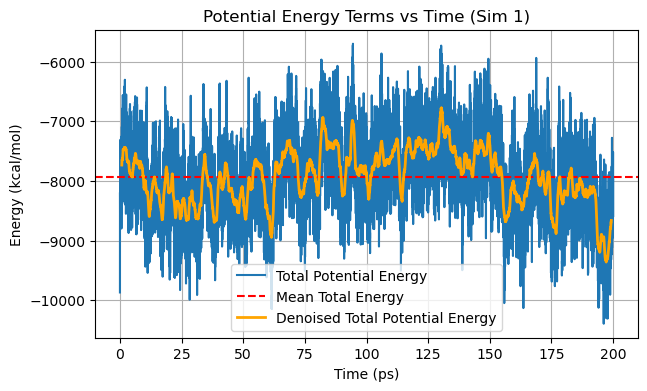

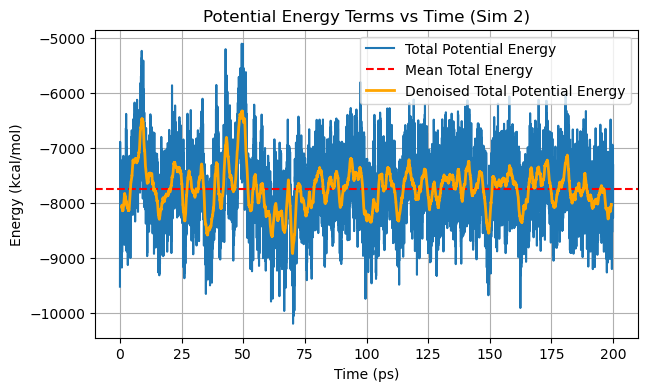

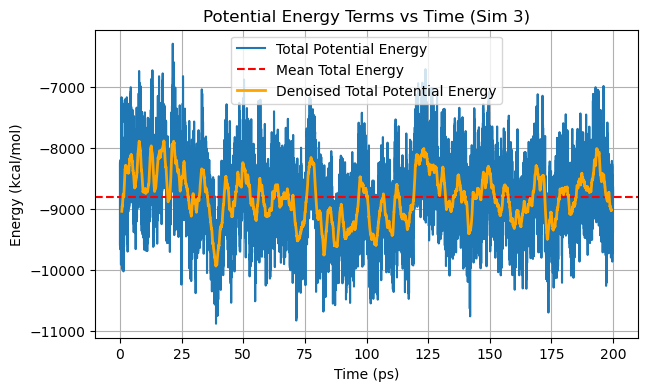

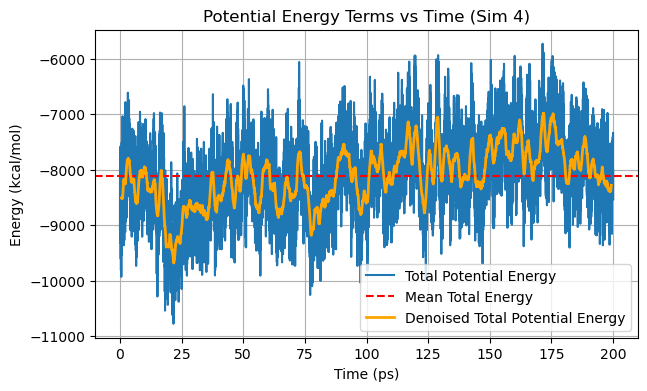

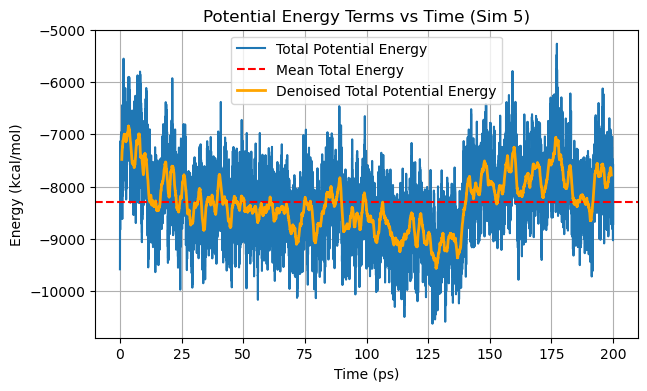

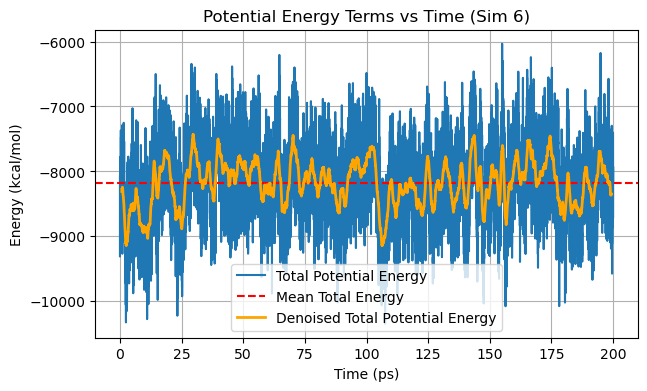

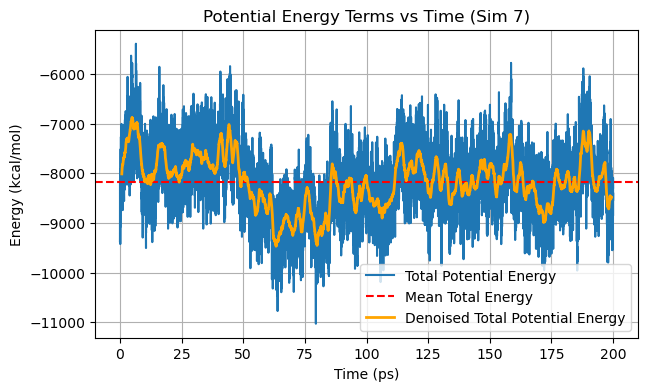

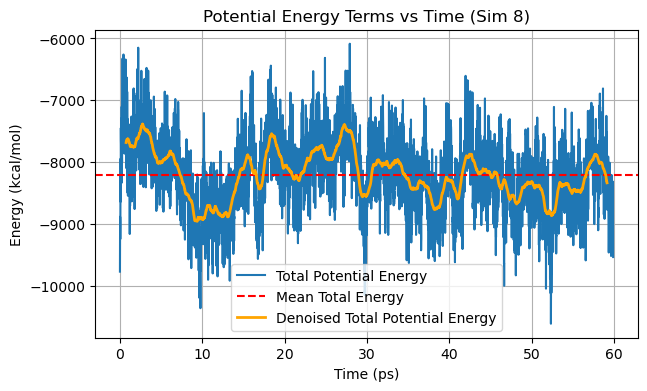

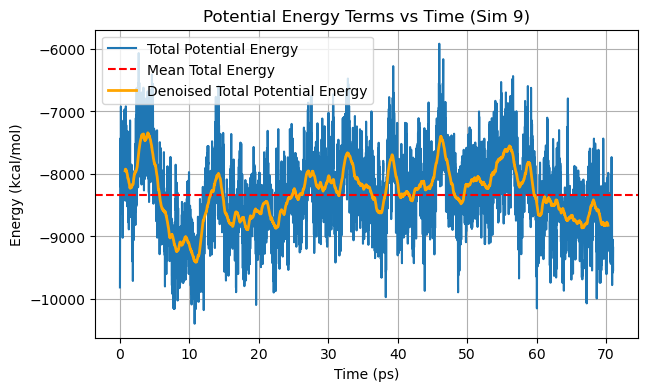

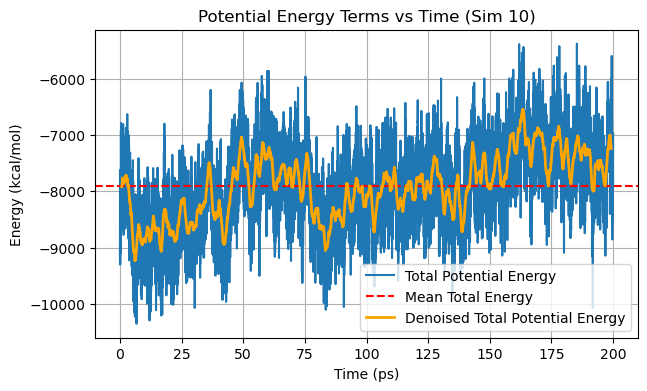

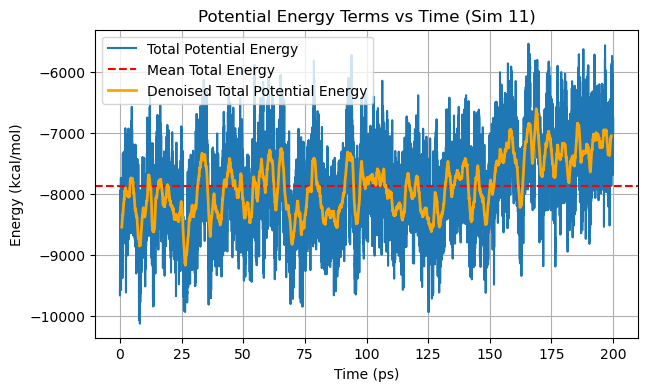

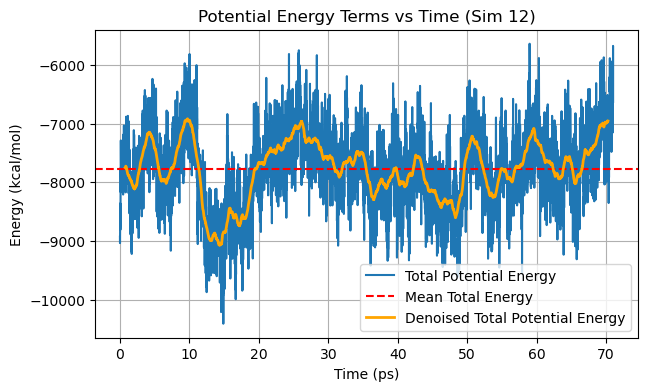

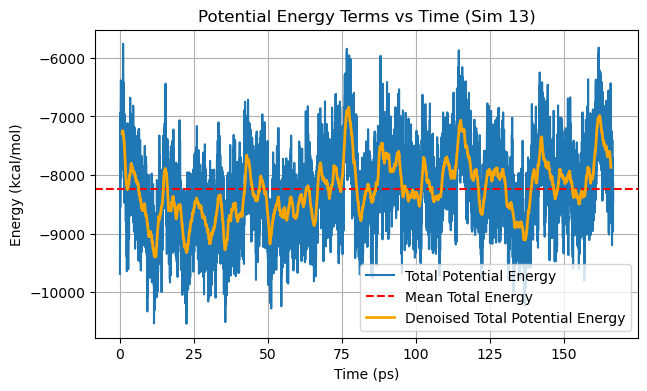

In [213]:
# Plotting the enregy profiles
for i in range(1, nsims):
    sim_path = base_path + f"sim_{i:03d}/"

    energy_file = sim_path + "protein_energy.csv"
    plot_path = base_path + "plots/potential_energy/"
    os.makedirs(plot_path, exist_ok=True)
    
    # the .csv headers are: time_fs,bond,angle,torsion,nonbonded,one_four,total_potential,kinetic
    # plot the histograms for the energy terms
    energy_df = pd.read_csv(energy_file)
    # Convert time from fs to ns
    energy_df['time_ps'] = energy_df['time_fs'] / 1000 / 1000
    # Plot the total energy
    plt.figure(figsize=(7, 4))
    # plot the potential energy
    plt.plot(energy_df['time_ps'], energy_df['total_potential'], label='Total Potential Energy')
    plt.axhline(y=(energy_df['total_potential']).mean(), color='r', linestyle='--', label='Mean Total Energy')
    # plt.fill_between(
    #     energy_df['time_ps'],
    #     energy_df['total_potential'].mean() - energy_df['total_potential'].std(),
    #     energy_df['total_potential'].mean() + energy_df['total_potential'].std(),
    #     color='r', alpha=0.2, label='±1 Std Dev'
    # )
    # Add a denoised version using a rolling mean
    window_size = 150  # Adjust the window size as needed
    energy_df['denoised_total_potential'] = energy_df['total_potential'].rolling(window=window_size, center=True).mean()
    plt.plot(energy_df['time_ps'], energy_df['denoised_total_potential'], label='Denoised Total Potential Energy', color='orange', linewidth=2)
    plt.xlabel('Time (ps)')
    plt.ylabel('Energy (kcal/mol)')
    plt.title(f'Potential Energy Terms vs Time (Sim {i})')
    plt.legend()
    plt.grid()
    plt.savefig(plot_path + f"energy_terms_sim_{i}.png", dpi=300, bbox_inches='tight')
    plt.show()



In [223]:
# extract the atom coordinates from the trajectory files and save as .npy files
def extract_coordinates(traj_file, output_file):
    u = mda.Universe(traj_file)
    # Select all atoms
    all_atoms = u.select_atoms("all")
    # Extract coordinates for all frames
    coordinates = []
    for ts in u.trajectory:
        coordinates.append(all_atoms.positions)
    coordinates = np.array(coordinates)
    # Save to .npy file
    np.save(output_file, coordinates)

def plot_atom_distance(trajectory, atom_1, atom_2, window_size=150, title="Distance between Atoms over Time", save_path=None, return_data=False):
    distances = np.linalg.norm(trajectory[:, atom_1] - trajectory[:, atom_2], axis=1)
    time_ns = np.linspace(0, 200*(len(distances)+1)/20000, len(distances))
    rolling_distances = pd.Series(distances).rolling(window=window_size, center=True).mean()
    plt.figure(figsize=(7, 4))
    plt.plot(time_ns, distances, label='Distance')
    plt.plot(time_ns, rolling_distances, label='Denoised Distance', color='orange', linewidth=2)
    plt.xlabel('Time (ns)')
    plt.ylabel('Distance (Å)')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    if save_path:
        dir = os.path.dirname(save_path)
        os.makedirs(dir, exist_ok=True)
        plt.savefig(save_path)
    else:
        plt.show()
    plt.close()
    if return_data:
        return distances

In [224]:
# Loop through the simulations and extract coordinates
for i in range(1, nsims):
    # base_path = f"Simulations/Apo/simulations/"
    sim_path = base_path + f"sim_{i:03d}/"
    traj_file = sim_path + "traj.dcd"
    output_file = sim_path + "coordinates.npy"
    extract_coordinates(traj_file, output_file)
    
    # plot the distance between two atoms (optional)
    coordinates = np.load(output_file)
    time_proxy = plot_atom_distance(coordinates, 158, 3286, window_size=150, 
                       title="Distance between Ca Atoms in TRP`10 and in TYR`210 over Time",
                       save_path=base_path + f"plots/distance10_210/distance_plot_{i}.png", return_data=True)
    np.save(sim_path + "time_proxy.npy", time_proxy)

/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/core/universe.py:1672: UserWarning: there is no reference attributes in this universe to guess types from
  warnings.warn(str(e))
/home/ubuntu22/miniconda3/envs/md/lib/python3.10/site-packages/MDAnalysis/core/universe.py:1672: UserWarning: there is no reference attributes (elements, types, or names) in this universe to guess mass from
  warnings.warn(str(e))


In [218]:
# Collect distance data from all trajectories
atom_1 = 158  # TRP`10
atom_2 = 3286  # TYR`210
all_distances = []
for i in range(1, nsims):
    sim_path = base_path + f"sim_{i:03d}/"
    output_file = sim_path + "coordinates.npy"
    coordinates = np.load(output_file)
    
    # Calculate distances between the specified atoms
    distances = np.linalg.norm(coordinates[:, atom_1] - coordinates[:, atom_2], axis=1)
    all_distances.append(distances)

<Figure size 1000x500 with 0 Axes>

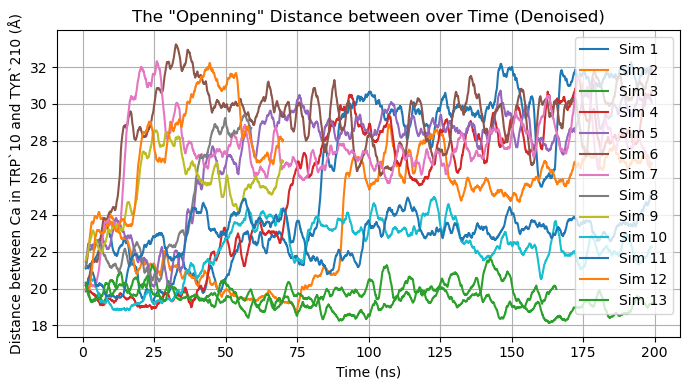

In [219]:
window_size = 200  # Adjust the window size as needed

# Plot all distances in one figure
plt.figure(figsize=(7, 4))
for i, distances in enumerate(all_distances, start=1):
    time_ns = np.linspace(0, 200*(len(distances)+1)/20000, len(distances))  # Assuming 200 ns simulation
    rolling_distances = pd.Series(distances).rolling(window=window_size, center=True).mean()
    plt.plot(time_ns, rolling_distances, label=f'Sim {i}')

plt.xlabel('Time (ns)')
plt.ylabel('Distance between Ca in TRP`10 and TYR`210 (Å)')
plt.title('The \"Openning\" Distance between over Time (Denoised)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [162]:
last_valid_index = rolling_distances.last_valid_index()
last_valid_value = rolling_distances.loc[last_valid_index]
print(f"Last non-NaN index: {last_valid_index}, Value: {last_valid_value}")

Last non-NaN index: 19499, Value: 21.957245738983154


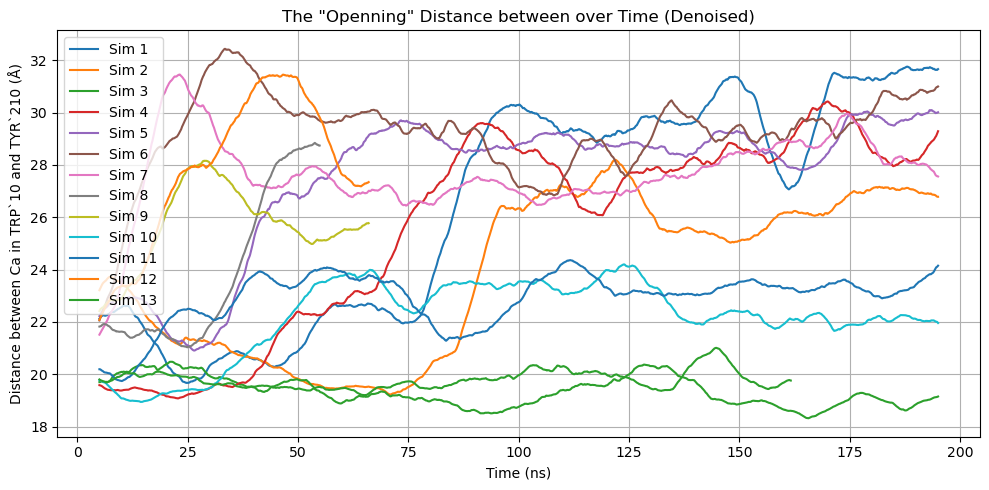

In [220]:
window_size = 1000  # Adjust the window size as needed

# Plot all distances in one figure
plt.figure(figsize=(10, 5))
for i, distances in enumerate(all_distances, start=1):
    time_ns = np.linspace(0, 200*(len(distances)+1)/20000, len(distances))  # Assuming 200 ns simulation
    rolling_distances = pd.Series(distances).rolling(window=window_size, center=True).mean()
    plt.plot(time_ns, rolling_distances, label=f'Sim {i}')

plt.xlabel('Time (ns)')
plt.ylabel('Distance between Ca in TRP`10 and TYR`210 (Å)')
plt.title('The \"Openning\" Distance between over Time (Denoised)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

<Figure size 700x400 with 0 Axes>

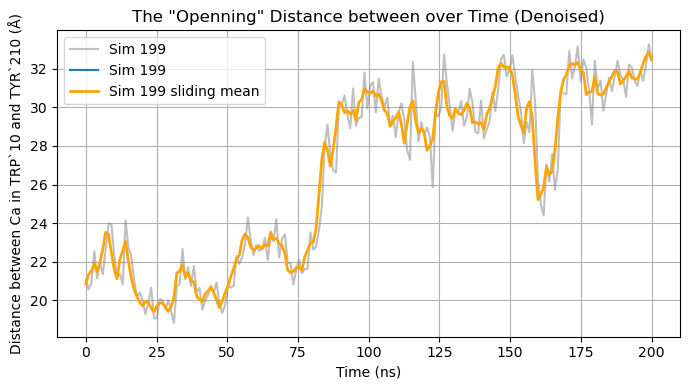

In [105]:
# Plot all distances in one figure
plt.figure(figsize=(7, 4))
# for i, distances in enumerate(all_distances, start=1):
distances = all_distances[0][::100]
time_ns = np.linspace(0, 200, len(distances))  # Assuming 200 ns simulation
rolling_distances = pd.Series(distances).rolling(window=window_size, center=True).mean()
plt.plot(time_ns, distances, label=f'Sim {i}', color='grey', alpha=0.5)
plt.plot(time_ns, rolling_distances, label=f'Sim {i}')

rolling_distances = []
for i in range(distances.shape[0]):
    rolling_distances.append(distances[i:i+3].mean())
plt.plot(time_ns, rolling_distances, label=f'Sim {i} sliding mean', color='orange', linewidth=2)

plt.xlabel('Time (ns)')
plt.ylabel('Distance between Ca in TRP`10 and TYR`210 (Å)')
plt.title('The \"Openning\" Distance between over Time (Denoised)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [31]:
# load a .npy trajetory for test
trajectory_file = base_path + "sim_001/coordinates.npy"
trajectory = np.load(trajectory_file)
# Check the shape of the trajectory
print(f"Trajectory shape: {trajectory.shape}")
# The shape should be (num_frames, num_atoms, 3)

Trajectory shape: (19999, 5737, 3)


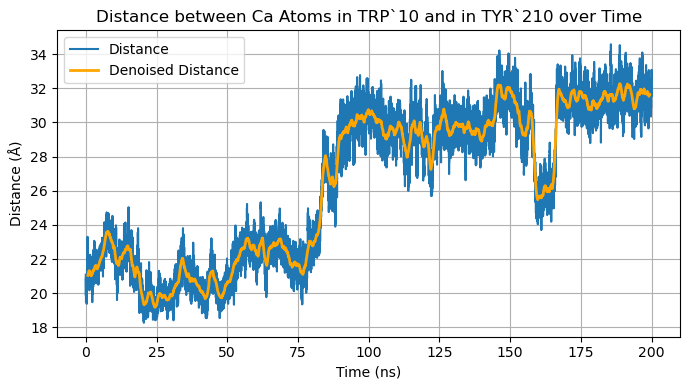

In [38]:
def plot_atom_distance(trajectory, atom_1, atom_2, window_size=150, title="Distance between Atoms over Time", save_path=None):
    distances = np.linalg.norm(trajectory[:, atom_1] - trajectory[:, atom_2], axis=1)
    time_ns = np.linspace(0, 200, len(distances))
    rolling_distances = pd.Series(distances).rolling(window=window_size, center=True).mean()
    plt.figure(figsize=(7, 4))
    plt.plot(time_ns, distances, label='Distance')
    plt.plot(time_ns, rolling_distances, label='Denoised Distance', color='orange', linewidth=2)
    plt.xlabel('Time (ns)')
    plt.ylabel('Distance (Å)')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

plot_atom_distance(trajectory, 158, 3286, window_size=150, title="Distance between Ca Atoms in TRP`10 and in TYR`210 over Time")


In [221]:
# Loop through the simulations and extract coordinates
distances_all = []
for i in range(1, nsims):
    # base_path = f"Simulations/Apo/simulations/"
    sim_path = base_path + f"sim_{i:03d}/"
    traj_file = sim_path + "traj.dcd"
    output_file = sim_path + "coordinates.npy"
    
    coordinates = np.load(output_file)
    
    atom_1, atom_2 = 158, 3286
    distances = np.linalg.norm(coordinates[:, atom_1] - coordinates[:, atom_2], axis=1)
    
    distances_all.append(distances)


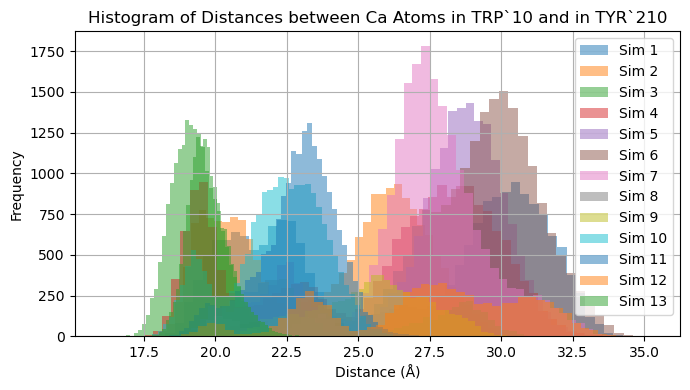

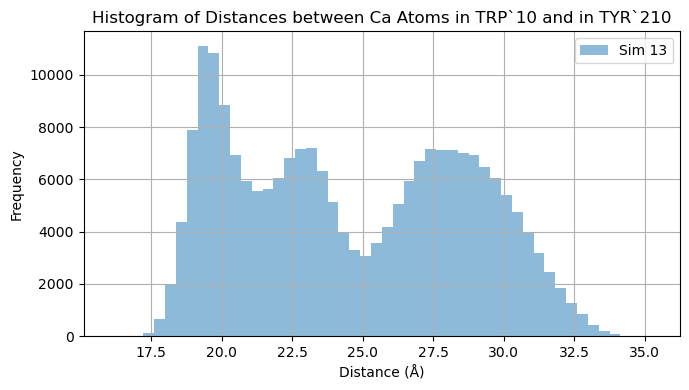

In [222]:
# Plot histogram of distances
plt.figure(figsize=(7, 4))
for i, distances in enumerate(distances_all, start=1):
    plt.hist(distances, bins=50, alpha=0.5, label=f'Sim {i}')
plt.xlabel('Distance (Å)')
plt.ylabel('Frequency')
plt.title('Histogram of Distances between Ca Atoms in TRP`10 and in TYR`210')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot histogram of distances
plt.figure(figsize=(7, 4))
# concatenate all distances into a single array
all_distances = np.concatenate(distances_all)
plt.hist(np.concatenate(distances_all), bins=50, alpha=0.5, label=f'Sim {i}')
plt.xlabel('Distance (Å)')
plt.ylabel('Frequency')
plt.title('Histogram of Distances between Ca Atoms in TRP`10 and in TYR`210')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



In [216]:
# Loop through the simulations and extract coordinates
distances_all = []
distances_all_ids = []

for i in range(1, nsims):
    if i in [3, 10, 11, 13]:
        continue
    # base_path = f"Simulations/Apo/simulations/"
    sim_path = base_path + f"sim_{i:03d}/"
    traj_file = sim_path + "traj.dcd"
    output_file = sim_path + "coordinates.npy"
    
    coordinates = np.load(output_file)
    distances_all_ids.append(i)
    
    atom_1, atom_2 = 158, 3286
    distances = np.linalg.norm(coordinates[:, atom_1] - coordinates[:, atom_2], axis=1)
    
    distances_all.append(distances)


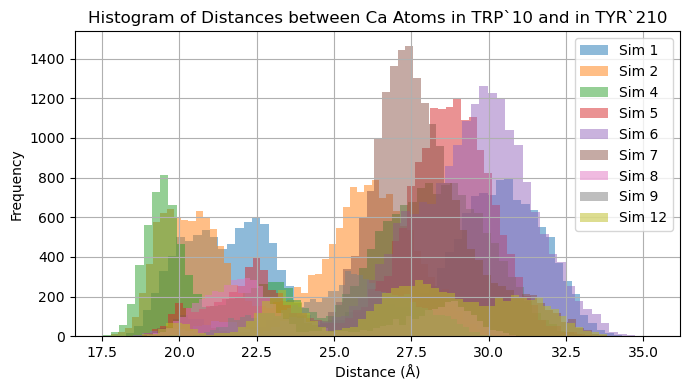

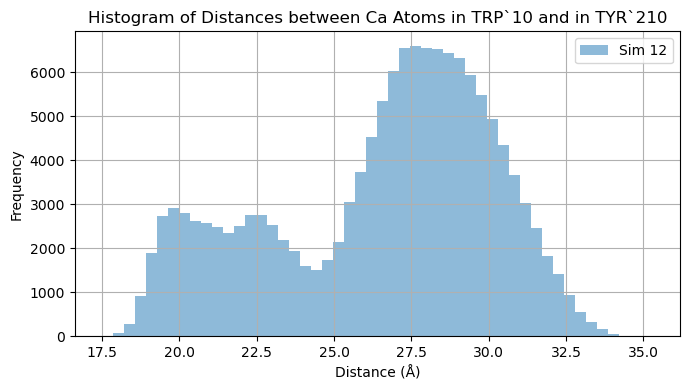

In [186]:
# Plot histogram of distances
plt.figure(figsize=(7, 4))
for i, distances in zip(distances_all_ids, distances_all):
    plt.hist(distances, bins=60, alpha=0.5, label=f'Sim {i}')
plt.xlabel('Distance (Å)')
plt.ylabel('Frequency')
plt.title('Histogram of Distances between Ca Atoms in TRP`10 and in TYR`210')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot histogram of distances
plt.figure(figsize=(7, 4))
# concatenate all distances into a single array
all_distances = np.concatenate(distances_all)
plt.hist(np.concatenate(distances_all), bins=50, alpha=0.5, label=f'Sim {i}')
plt.xlabel('Distance (Å)')
plt.ylabel('Frequency')
plt.title('Histogram of Distances between Ca Atoms in TRP`10 and in TYR`210')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



In [ ]:
# Loop through the simulations and extract coordinates
md_selection = {
    1: (45, 105),
    2: (75, 125),
    4: (25, 95),
    5: (25, 75),
    6: (0, 35),
    7: (0, 25),
    8: (20, -1),
    9: (0, 30), 
    10: (10, 70),
    11: (0, 55),
    12: (0, 50),
}

distances_all = []
distances_all_ids = []

for i, (start, end) in md_selection.items():
    sim_path = base_path + f"sim_{i:03d}/"
    traj_file = sim_path + "traj.dcd"
    output_file = sim_path + "coordinates.npy"
    
    coordinates = np.load(output_file)
    distances_all_ids.append(i)
    
    atom_1, atom_2 = 158, 3286
    distances = np.linalg.norm(coordinates[:, atom_1] - coordinates[:, atom_2], axis=1)
    
    if end == -1:
        distances_all.append(distances)
    else:
        end = end * 100
        distances = distances[start:end]
        distances_all.append(distances)


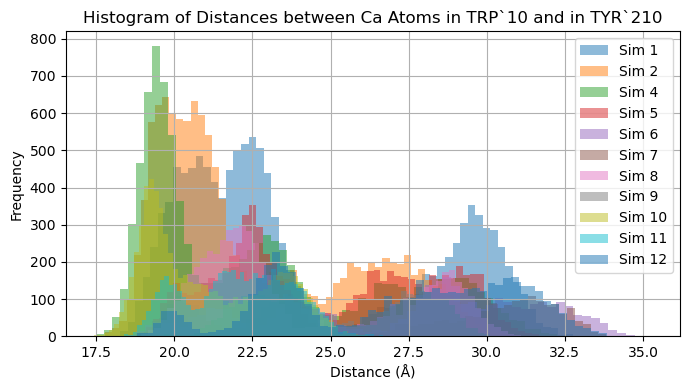

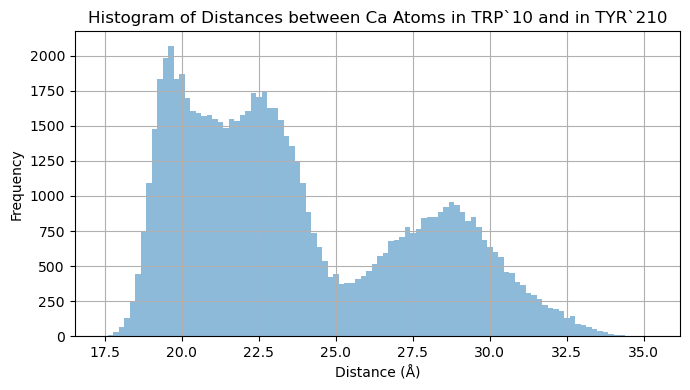

In [211]:
# Plot histogram of distances
plt.figure(figsize=(7, 4))
for i, distances in zip(md_selection.keys(), distances_all):
    plt.hist(distances, bins=60, alpha=0.5, label=f'Sim {i}')
plt.xlabel('Distance (Å)')
plt.ylabel('Frequency')
plt.title('Histogram of Distances between Ca Atoms in TRP`10 and in TYR`210')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot histogram of distances
plt.figure(figsize=(7, 4))
# concatenate all distances into a single array
all_distances = np.concatenate(distances_all)
plt.hist(np.concatenate(distances_all), bins=100, alpha=0.5)
plt.xlabel('Distance (Å)')
plt.ylabel('Frequency')
plt.title('Histogram of Distances between Ca Atoms in TRP`10 and in TYR`210')
plt.grid()
plt.tight_layout()
plt.show()

